In [106]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
from astropy.timeseries import LombScargle
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import pickle

# Functions

In [107]:
def lorentzian_components(params_gr, t):

    '''
    Simulated effects of pulsations and granulations
    
    source: Dumusque et al 2011
    https://www.aanda.org/articles/aa/pdf/2011/01/aa14097-10.pdf
    
    Inputs
        - params_gr := A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste
        - t = time in seconds

    ''' 
    
    # define frequency arrays  
    # The frequency ν goes from 1/T to the Nyquist frequency in steps of 1/T
    N    = len(t)
    Ttot = (max(t)-min(t)) # total time in seconds
    dt = np.median(np.diff(t)) # sampling rate
    freq_Nyq = (1.0/dt)/2 # Nyquist frequency
    freq  = np.arange(1.0/Ttot,freq_Nyq,1.0/Ttot, dtype='float64')
    # freq  = np.linspace(1.0/Ttot, 1./2/dt, len(t)) # Hz

    # define the power spectra as a sum of 3 components for granulation, mesogranulation and supergranulation + oscillations
    A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste = params_gr 
    
    VPSD = A1 / (1+(B1*freq)**C1) + A2 / (1+(B2*freq)**C2) +  A3 / (1+(B3*freq)**C3) + \
                AL * (Gm**2/((freq-nu0)**2+Gm**2)) +  cste  
    
    #VPSD /= 1e6     # units of VPSD is (m/s)**2/Hz
    VPSD *= (freq[-1] - freq[0])*1e6
           
    # take random phase between 0 and 2pi
    phase = 2*np.pi*np.random.rand(1,len(VPSD))
    #print(len(phase), len(VPSD))
    
    # Synthetic radial velocity measurements
    ysyn = np.zeros(N)
    for i in range(N):
        ysyn[i] = np.sum(np.sqrt(VPSD)*np.sin(2*np.pi*t[i]*freq+phase))
       
    return ysyn




def generate_regular_data_H0(params_gr, params_act, N, t):
    
    '''
    Inputs:
    - params_gr:= 
            see function lorentzian_components(params_gr, t)
    - params_act:=
            - amplitude (GP amplitude)
            - gam = 2/epsilon in the paper (GP gamma)
            - logP = log(P) in the paper (GP period)
            - met = 1.0 in the paper (GP metric)
    
    - N = number of data points
        
    Outputs:
        - t = time (days)
        - y = RV (m/s)
        - yerr =  intrinsic errors (m/s)
    '''
    
    # =========================================================================
    # Generate a Lorentzian component that represents the pulsations and
    # three components for the granulation, mesogranulation and su-
    # pergranulation
    ts    = t*24*3600 # seconds
    ygr = lorentzian_components(params_gr, ts)
    
    # =========================================================================
    # Generate activity component based on GP
    
    # define the QP kernel for the GP (see https://george.readthedocs.io/en/latest/user/kernels/)
    amp, gam, logP, met  = params_act
    k  = kernels.ExpSine2Kernel(gamma=gam, log_period=logP)
    k *= kernels.ExpSquaredKernel(metric=met) # metric correspondind to r^2/lambda  is 1
    k *= amp**2 
    # print(k.get_parameter_vector())
    
    gp = george.GP(k)

    # generate synthetic dataset
    yact = gp.sample(ts)
    
    # =========================================================================
    # Generate the intrincsic errors
    sig = 0.30 # m/s
    yerr = np.random.normal(loc=0, scale=sig, size=N) # this has to be defined according to the paper
    #print('std(yerr) = %f m/s'%np.std(yerr))

    # =========================================================================
    # Generate the final synthetic time series
    # activity + granulation + the intrinsic errors 
    ytot = ygr + yact + yerr * np.random.randn(N)
    
    #return ygr,yact, yerr
    return ytot, yerr




def generate_planete(params_pl,t):
    """
    - params_pl
            - Ppl (Orbital period)
            - K (semi-amplitude)
            - T0 ( Phase à l'origine)
    """
    Ppl, K, T0 = params_pl
    return K*np.sin(2*np.pi*(t-T0)/Ppl)



def print_4periodogramme(LS_p,label,freq_pl,i):
    LS = LS_p[:,i,:]
    f1,f2,f3,f4 = freq_pl[i,:]
    l1,l2,l3,l4 = label[i,:]
    
    plt.figure()
    plt.suptitle("4 Lomb-Scargle peridogramme generated by removing the best fit\n"+str(i)+" planet")
    plt.subplot(411),plt.plot(freq, LS[:,0] , label =l1), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,0]),max(LS[:,0])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,0]),max(LS[:,0])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,0]),max(LS[:,0])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,0]),max(LS[:,0])],'y--')

    plt.subplot(412), plt.plot(freq, LS[:,1] , label =l2), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,1]),max(LS[:,1])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,1]),max(LS[:,1])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,1]),max(LS[:,1])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,1]),max(LS[:,1])],'y--')

    plt.subplot(413), plt.plot(freq, LS[:,2] , label =l3), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,2]),max(LS[:,2])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,2]),max(LS[:,2])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,2]),max(LS[:,2])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,2]),max(LS[:,2])],'y--')

    plt.subplot(414 ), plt.plot(freq, LS[:,3] , label = l4), plt.legend()
    if (f1!=0) : plt.plot([f1,f1] , [min(LS[:,3]),max(LS[:,3])],'r--')
    if (f2!=0) : plt.plot([f2,f2] , [min(LS[:,3]),max(LS[:,3])],'g--')
    if (f3!=0) : plt.plot([f3,f3] , [min(LS[:,3]),max(LS[:,3])],'b--')
    if (f4!=0) : plt.plot([f4,f4] , [min(LS[:,3]),max(LS[:,3])],'y--')
    
    plt.xlabel("Frequency (day⁻¹)")
    plt.ylabel("Power")
    

def generate_4_periodogrammes(t,f, y, freq_pl,nbr_planete):
    """
    Parameters
    ----------
    t : time (day)
    f : frequency ( day⁻1)
    y : original time serie

    Returns
    -------
    4 times series with their lomb-scargle 
    """
    y_t = np.zeros((len(t), 4)) #time series
    LS  = np.zeros((len(f), 4)) # 4 lombscargle 
    nbr_planete_now = np.copy(nbr_planete)
    label= np.zeros(4) #(1 if max = freq_pl, 0 else)
    max_value = np.zeros((2,4)) # (argmax, max)
    
    y_t[:,0] = y 
    
    for i in range(3):
        LS_i =  LombScargle(t, y_t[:,i])
        LS[:,i] = LS_i.power(f,method='cython')
        best_freq = round(f[np.argmax(LS[:,i])],3)
        #print("meilleur fit : ",best_freq)
        max_value[0,i], max_value[1,i] = best_freq, np.max(LS[:,i]) 
                
        if ( any(np.isclose(freq_pl, best_freq, atol=0.003)) ):
            label[i] = 1
            freq_pl[ np.where( np.isclose(freq_pl, best_freq, atol=0.003) ) ] = 0
            nbr_planete_now[i+1:] = nbr_planete_now[i] - 1
        else:
            label[i] = 0
            
        y_fit = LS_i.model(t,best_freq)
        y_t[:,i+1] = y_t[:,i] - y_fit
      
    LS_i = LombScargle(t, y_t[:,3])
    LS[:,3] = LS_i.power(f,method='cython')
    best_freq = round(f[np.argmax(LS[:,3])],3)
    #print("meilleur fit : ",best_freq)
    max_value [0,3], max_value[1,3] =  best_freq, np.max(LS[:,3])
    
    if (any(np.isclose(freq_pl, best_freq, atol=0.003))):
        label[3] = 1
        freq_pl[np.where( np.isclose(freq_pl, best_freq, atol=0.003) )] = 0
    else:
        label[3] = 0
    
    #print("label = ", label)
    
    return LS, label, max_value, nbr_planete_now     



def generate_data(t,dt,Ttot,freq,params_gr, params_act):
    
    """
    Create 5 time series with respectively 0, 1, 2, 3 and 4 planets. For each time series 4 Lomb-Scargle 
    periodogrammes are generated.For each periodogramme, position and max amplitude are taken and a label is 
    created, either 1 or 0 if max amplitude correspond to a frequency planeteray signal.
    """
    
    time_series = np.zeros((len(t),5))
    LS = np.zeros((len(freq),5,4))
    freq_pl = np.zeros((5,4))
    nbr_planete = np.zeros((5,4))
    label = np.zeros((5,4))
    max_value = np.zeros((2,5,4))
    
    y_noise, yerr = generate_regular_data_H0(params_gr, params_act, len(t), t) 
    
    #print("freq planet : ",freq_pl[0,:])
    time_series[:,0] = y_noise #Without planet
    LS[:,0,:], label[0,:], max_value[:,0,:],nbr_planete[0,:] = generate_4_periodogrammes(t, freq, np.copy(y_noise), freq_pl[0,:],nbr_planete[0,:]) #Without planet
    
    for i in range(1,5):
        y_i = y_noise
        for k in range(1,i+1):
            Ppl =  random.uniform(10*dt,Ttot/2) 
            K = loguniform.rvs(0.1, 10)
            T0 =  random.uniform(0,Ppl)
            params_pl = [Ppl,K,T0]
            freq_pl[i,k-1] = round(1/Ppl,3)
            
            y_pl = generate_planete(params_pl, t)
            y_i += y_pl 
        
        
        nbr_planete[i,:] = i
        #print("freq planet : ",freq_pl[i,:])
        time_series[:,i] = y_i
        LS[:,i,:], label[i,:], max_value[:,i,:],nbr_planete[i,:] = generate_4_periodogrammes(t, freq, y_i,np.copy(freq_pl[i,:]),nbr_planete[i,:])
        
        
    return time_series, LS, label, max_value, freq_pl,nbr_planete


In [108]:
#Function to create the first dataset
def create_set1(nbr_periodogramme, pourcentage_positive,t, dt, Ttot, freq):
    
    count_positif = 0
    count_negatif = 0
    nbr_ech = nbr_periodogramme/5
    count_ech = np.zeros(5)
    
    X_LS = []
    X_max_values = []
    Y = []
    
    start = time.time()
    
    A1, A2, A3  = 0.027, 0.003, 0.3*1e-3 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    #create 40% positif label
    while( count_positif < pourcentage_positive*nbr_periodogramme) :
        ##Activity signal
        Prot = random.randint(10,90)*3600*24#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot) 
        gam  = 2.0/epsilon #not change
        logP = np.log(Prot) #not change 
        met  = 1.0 # not change 

        params_act = [amp, gam, logP, met]
        
        #Create time serie
        time_series, LS, label, max_value, freq_pl, nbr_planete = generate_data(t, dt, Ttot, freq, params_gr, params_act)

        for i in range(1,5):
            for j in range(4):
                if (label[i,j] == 1):
                    X_LS.append(LS[:,i,j])
                    X_max_values.append(max_value[:,i,j])
                    Y.append(1)
                    count_positif +=1
                    count_ech[ round(nbr_planete[i,j]) ] +=1
    
        print("Nbr positif label : ",count_positif)
        print("Nbr ech par cas de figure : ", count_ech)
        
    print("\nPositive label termined, nbr count positive label = ", count_positif)    
    print("Nbr ech par cas de figure : ", count_ech,"\n")
    nbr_planet_cas_positif = np.copy(count_ech)
    time.sleep(5)
    
    
    #create negatif label 
    while ( (count_negatif < (1-pourcentage_positive)) or (any(count_ech<nbr_ech)) ):
      
        ##Activity signal
        Prot = random.randint(10,90)*3600*24#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot) 
        gam  = 2.0/epsilon #not change
        logP = np.log(Prot) #not change 
        met  = 1.0 # not change 

        params_act = [amp, gam, logP, met]
        
        #Create time serie
        time_series, LS, label, max_value, freq_pl, nbr_planete = generate_data(t, dt, Ttot, freq, params_gr, params_act)

        for i in range(5):
            for j in range(4):
                
                if ( (label[i,j] == 0)  and (count_ech[ round(nbr_planete[i,j]) ] < nbr_ech) ):
                        X_LS.append(LS[:,i,j])
                        X_max_values.append(max_value[:,i,j])
                        Y.append(0)
                        count_ech[ round(nbr_planete[i,j]) ] +=1
                        count_negatif += 1
                        
        print("nbr ech ",count_ech)
        print("count negatif = ",count_negatif)

    
    
    print("\nTemps total = ", round(time.time() - start,2))
    print("Nbr ech par cas de figure : ", count_ech)
    print("Nbr positive label : ",count_positif, ", Nbr negative label : ",count_negatif)
    
    print("\nRepartition label positif sur le nombre de planete : ")
    print(" - 0 planete ", 100*round(nbr_planet_cas_positif[0]/count_positif,3),"%")
    print(" - 1 planete ", 100*round(nbr_planet_cas_positif[1]/count_positif,3),"%")
    print(" - 2 planetes ", 100*round(nbr_planet_cas_positif[2]/count_positif,3),"%")
    print(" - 3 planetes ", 100*round(nbr_planet_cas_positif[3]/count_positif,3),"%")
    print(" - 4 planetes ", 100*round(nbr_planet_cas_positif[4]/count_positif,3),"%")
    
    print("Repartition label negatif sur le nombre de planete : ")
    print(" - 0 planete ", 100*round((count_ech[0]-nbr_planet_cas_positif[0])/count_negatif,3),"%")
    print(" - 1 planete ", 100*round((count_ech[1]-nbr_planet_cas_positif[1])/count_negatif,3),"%")
    print(" - 2 planetes ", 100*round((count_ech[2]-nbr_planet_cas_positif[2])/count_negatif,3),"%")
    print(" - 3 planetes ", 100*round((count_ech[3]-nbr_planet_cas_positif[3])/count_negatif,3),"%")
    print(" - 4 planetes ", 100*round((count_ech[4]-nbr_planet_cas_positif[4])/count_negatif,3),"%")
    
    print("\nRepartion classe positif/negatif : ", 100*round(count_positif/len(X_LS),2),"% , ", 100*round(count_negatif/len(X_LS),2),"%")
    
    print("\nNbr data : ", len(Y) )
    
    return X_LS, X_max_values, Y

In [109]:
#Function to create the second dataset
def create_set(nbr_periodogramme,t, dt, Ttot, freq):
    
    nbr_ech = nbr_periodogramme/5
    count_ech = np.zeros(5)
    
    
    X_LS = []
    X_max_values = []
    Y = []
    F = []
    
    A1, A2, A3  = 0.027, 0.003, 0.3*1e-3 # m/s
    B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
    C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
    AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
    cste        = 1.4e-4 # (m/s)**2/Hz

    params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
    while ( any(count_ech<nbr_ech) ) :
      
        ##Activity signal
        Prot = random.randint(10,90)*3600*24#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

        amp  = gamma.rvs(2.0, 0.5) 
        epsilon = uniform.rvs(0.5, 1)
        tau = np.random.normal(3*Prot, 0.1*Prot) 
        gam  = 2.0/epsilon #not change
        logP = np.log(Prot) #not change 
        met  = 1.0 # not change 

        params_act = [amp, gam, logP, met]
        
        #Create time serie
        time_series, LS, label, max_value, freq_pl, nbr_planete = generate_data(t, dt, Ttot, freq, params_gr, params_act)


        for i in range(5):
            for j in range(4):
                if ( count_ech[ round(nbr_planete[i,j]) ] < nbr_ech):
                        X_LS.append(LS[:,i,j])
                        X_max_values.append(max_value[:,i,j])
                        Y.append(label[i,j])
                        count_ech[ round(nbr_planete[i,j]) ] +=1
                        F.append(freq_pl[i,j])
                        
        print("Nbr ech par cas de figure : ", count_ech)
        
    
    print("Nbr ech par cas de figure : ", count_ech)
    print("Nbr d'echantillons positif : ", Y.count(1))
    print("Nbr d'echantillons negatif : ", Y.count(0))  
    
    return X_LS, X_max_values, Y, F

# Call functions to create dataset

In [110]:
#Generate time and frequency
#Over-sampling
Ttot = 200 # days
facteur_surech = 10
N = Ttot*facteur_surech +1 # number of data point in a regularly sampled grid
t_over = np.linspace(0,Ttot,N) #days
dt = Ttot*facteur_surech/(N-1) #After sampling


# Irregular sampling 1 : with normal distribution
facteur_ech = 20
t = np.zeros(Ttot)

ind0 = round( 0 + facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[0] = t_over[ ind0 ]
ind_fin = round( (N-1) - facteur_ech*np.abs(np.random.normal(0, 0.1)))
t[-1] = t_over[ ind_fin ]

pas = N/Ttot
for i in range(Ttot-2):
    ind = round((i+1)*pas+facteur_ech*np.random.normal(0, 0.1))
    t[i+1] =  t_over[ind]
    
fmin = 1/(t[-1]-t[0])
fmax = (1/dt)/2 
freq = np.linspace(fmin,fmax,990)


In [111]:
#create set 1
nbr_periodogramme_set1 = 13700
pourcentage_positive = 0.4
X_LS, X_max_values, Y = create_set1(nbr_periodogramme_set1,pourcentage_positive,t, dt, Ttot, freq)

Nbr positif label :  3
Nbr ech par cas de figure :  [0. 0. 1. 1. 1.]
Nbr positif label :  7
Nbr ech par cas de figure :  [0. 1. 2. 2. 2.]
Nbr positif label :  11
Nbr ech par cas de figure :  [0. 2. 4. 3. 2.]
Nbr positif label :  17
Nbr ech par cas de figure :  [0. 4. 5. 5. 3.]
Nbr positif label :  23
Nbr ech par cas de figure :  [0. 5. 7. 7. 4.]
Nbr positif label :  29
Nbr ech par cas de figure :  [0. 6. 9. 9. 5.]
Nbr positif label :  36
Nbr ech par cas de figure :  [ 0.  8. 11. 11.  6.]
Nbr positif label :  39
Nbr ech par cas de figure :  [ 0.  9. 11. 12.  7.]
Nbr positif label :  46
Nbr ech par cas de figure :  [ 0. 11. 13. 14.  8.]
Nbr positif label :  50
Nbr ech par cas de figure :  [ 0. 11. 15. 15.  9.]
Nbr positif label :  54
Nbr ech par cas de figure :  [ 0. 11. 17. 16. 10.]
Nbr positif label :  60
Nbr ech par cas de figure :  [ 0. 12. 19. 18. 11.]
Nbr positif label :  63
Nbr ech par cas de figure :  [ 0. 12. 19. 20. 12.]
Nbr positif label :  69
Nbr ech par cas de figure :  [ 0.

Nbr positif label :  557
Nbr ech par cas de figure :  [  0.  97. 175. 181. 104.]
Nbr positif label :  560
Nbr ech par cas de figure :  [  0.  98. 175. 182. 105.]
Nbr positif label :  565
Nbr ech par cas de figure :  [  0.  98. 177. 184. 106.]
Nbr positif label :  571
Nbr ech par cas de figure :  [  0.  99. 179. 186. 107.]
Nbr positif label :  574
Nbr ech par cas de figure :  [  0.  99. 179. 188. 108.]
Nbr positif label :  579
Nbr ech par cas de figure :  [  0. 100. 180. 190. 109.]
Nbr positif label :  585
Nbr ech par cas de figure :  [  0. 101. 182. 192. 110.]
Nbr positif label :  589
Nbr ech par cas de figure :  [  0. 101. 184. 193. 111.]
Nbr positif label :  593
Nbr ech par cas de figure :  [  0. 101. 186. 194. 112.]
Nbr positif label :  595
Nbr ech par cas de figure :  [  0. 102. 186. 194. 113.]
Nbr positif label :  599
Nbr ech par cas de figure :  [  0. 102. 187. 196. 114.]
Nbr positif label :  605
Nbr ech par cas de figure :  [  0. 104. 188. 198. 115.]
Nbr positif label :  611
Nbr

Nbr positif label :  1066
Nbr ech par cas de figure :  [  0. 179. 336. 347. 204.]
Nbr positif label :  1069
Nbr ech par cas de figure :  [  0. 179. 337. 348. 205.]
Nbr positif label :  1073
Nbr ech par cas de figure :  [  0. 180. 337. 350. 206.]
Nbr positif label :  1077
Nbr ech par cas de figure :  [  0. 181. 337. 352. 207.]
Nbr positif label :  1084
Nbr ech par cas de figure :  [  0. 183. 339. 354. 208.]
Nbr positif label :  1090
Nbr ech par cas de figure :  [  0. 184. 341. 356. 209.]
Nbr positif label :  1097
Nbr ech par cas de figure :  [  0. 185. 344. 358. 210.]
Nbr positif label :  1104
Nbr ech par cas de figure :  [  0. 187. 346. 360. 211.]
Nbr positif label :  1110
Nbr ech par cas de figure :  [  0. 188. 348. 362. 212.]
Nbr positif label :  1113
Nbr ech par cas de figure :  [  0. 188. 348. 364. 213.]
Nbr positif label :  1118
Nbr ech par cas de figure :  [  0. 189. 350. 365. 214.]
Nbr positif label :  1124
Nbr ech par cas de figure :  [  0. 191. 352. 366. 215.]
Nbr positif labe

Nbr positif label :  1577
Nbr ech par cas de figure :  [  0. 273. 490. 511. 303.]
Nbr positif label :  1583
Nbr ech par cas de figure :  [  0. 274. 492. 513. 304.]
Nbr positif label :  1590
Nbr ech par cas de figure :  [  0. 275. 495. 515. 305.]
Nbr positif label :  1597
Nbr ech par cas de figure :  [  0. 276. 498. 517. 306.]
Nbr positif label :  1602
Nbr ech par cas de figure :  [  0. 276. 500. 519. 307.]
Nbr positif label :  1608
Nbr ech par cas de figure :  [  0. 277. 502. 521. 308.]
Nbr positif label :  1613
Nbr ech par cas de figure :  [  0. 278. 503. 523. 309.]
Nbr positif label :  1619
Nbr ech par cas de figure :  [  0. 279. 505. 525. 310.]
Nbr positif label :  1623
Nbr ech par cas de figure :  [  0. 280. 505. 527. 311.]
Nbr positif label :  1629
Nbr ech par cas de figure :  [  0. 281. 507. 529. 312.]
Nbr positif label :  1634
Nbr ech par cas de figure :  [  0. 282. 509. 530. 313.]
Nbr positif label :  1638
Nbr ech par cas de figure :  [  0. 282. 510. 532. 314.]
Nbr positif labe

Nbr positif label :  2122
Nbr ech par cas de figure :  [  0. 369. 665. 685. 403.]
Nbr positif label :  2128
Nbr ech par cas de figure :  [  0. 370. 667. 687. 404.]
Nbr positif label :  2134
Nbr ech par cas de figure :  [  0. 371. 669. 689. 405.]
Nbr positif label :  2139
Nbr ech par cas de figure :  [  0. 371. 671. 691. 406.]
Nbr positif label :  2144
Nbr ech par cas de figure :  [  0. 372. 672. 693. 407.]
Nbr positif label :  2150
Nbr ech par cas de figure :  [  0. 373. 674. 695. 408.]
Nbr positif label :  2156
Nbr ech par cas de figure :  [  0. 374. 676. 697. 409.]
Nbr positif label :  2162
Nbr ech par cas de figure :  [  0. 375. 678. 699. 410.]
Nbr positif label :  2165
Nbr ech par cas de figure :  [  0. 375. 679. 700. 411.]
Nbr positif label :  2171
Nbr ech par cas de figure :  [  0. 376. 681. 702. 412.]
Nbr positif label :  2176
Nbr ech par cas de figure :  [  0. 377. 682. 704. 413.]
Nbr positif label :  2182
Nbr ech par cas de figure :  [  0. 377. 685. 706. 414.]
Nbr positif labe

Nbr positif label :  2670
Nbr ech par cas de figure :  [  0. 474. 829. 866. 501.]
Nbr positif label :  2674
Nbr ech par cas de figure :  [  0. 474. 830. 868. 502.]
Nbr positif label :  2677
Nbr ech par cas de figure :  [  0. 474. 831. 869. 503.]
Nbr positif label :  2680
Nbr ech par cas de figure :  [  0. 474. 832. 870. 504.]
Nbr positif label :  2683
Nbr ech par cas de figure :  [  0. 474. 832. 872. 505.]
Nbr positif label :  2689
Nbr ech par cas de figure :  [  0. 475. 834. 874. 506.]
Nbr positif label :  2695
Nbr ech par cas de figure :  [  0. 476. 836. 876. 507.]
Nbr positif label :  2700
Nbr ech par cas de figure :  [  0. 476. 838. 878. 508.]
Nbr positif label :  2707
Nbr ech par cas de figure :  [  0. 477. 841. 880. 509.]
Nbr positif label :  2711
Nbr ech par cas de figure :  [  0. 478. 841. 882. 510.]
Nbr positif label :  2716
Nbr ech par cas de figure :  [  0. 479. 843. 883. 511.]
Nbr positif label :  2722
Nbr ech par cas de figure :  [  0. 479. 846. 885. 512.]
Nbr positif labe

Nbr positif label :  3179
Nbr ech par cas de figure :  [   0.  561.  988. 1031.  599.]
Nbr positif label :  3184
Nbr ech par cas de figure :  [   0.  562.  989. 1033.  600.]
Nbr positif label :  3185
Nbr ech par cas de figure :  [   0.  562.  990. 1033.  600.]
Nbr positif label :  3187
Nbr ech par cas de figure :  [   0.  562.  990. 1034.  601.]
Nbr positif label :  3193
Nbr ech par cas de figure :  [   0.  563.  992. 1036.  602.]
Nbr positif label :  3202
Nbr ech par cas de figure :  [   0.  566.  995. 1038.  603.]
Nbr positif label :  3208
Nbr ech par cas de figure :  [   0.  567.  997. 1040.  604.]
Nbr positif label :  3215
Nbr ech par cas de figure :  [   0.  568. 1000. 1042.  605.]
Nbr positif label :  3221
Nbr ech par cas de figure :  [   0.  569. 1002. 1044.  606.]
Nbr positif label :  3226
Nbr ech par cas de figure :  [   0.  570. 1003. 1046.  607.]
Nbr positif label :  3231
Nbr ech par cas de figure :  [   0.  571. 1005. 1047.  608.]
Nbr positif label :  3237
Nbr ech par cas d

Nbr positif label :  3674
Nbr ech par cas de figure :  [   0.  646. 1145. 1191.  692.]
Nbr positif label :  3678
Nbr ech par cas de figure :  [   0.  646. 1146. 1193.  693.]
Nbr positif label :  3685
Nbr ech par cas de figure :  [   0.  648. 1148. 1195.  694.]
Nbr positif label :  3687
Nbr ech par cas de figure :  [   0.  649. 1148. 1195.  695.]
Nbr positif label :  3693
Nbr ech par cas de figure :  [   0.  650. 1150. 1197.  696.]
Nbr positif label :  3698
Nbr ech par cas de figure :  [   0.  650. 1152. 1199.  697.]
Nbr positif label :  3704
Nbr ech par cas de figure :  [   0.  651. 1154. 1201.  698.]
Nbr positif label :  3705
Nbr ech par cas de figure :  [   0.  651. 1154. 1202.  698.]
Nbr positif label :  3709
Nbr ech par cas de figure :  [   0.  651. 1155. 1204.  699.]
Nbr positif label :  3712
Nbr ech par cas de figure :  [   0.  651. 1156. 1205.  700.]
Nbr positif label :  3716
Nbr ech par cas de figure :  [   0.  651. 1157. 1207.  701.]
Nbr positif label :  3720
Nbr ech par cas d

Nbr positif label :  4174
Nbr ech par cas de figure :  [   0.  732. 1301. 1355.  786.]
Nbr positif label :  4179
Nbr ech par cas de figure :  [   0.  732. 1303. 1357.  787.]
Nbr positif label :  4184
Nbr ech par cas de figure :  [   0.  733. 1304. 1359.  788.]
Nbr positif label :  4191
Nbr ech par cas de figure :  [   0.  735. 1306. 1361.  789.]
Nbr positif label :  4197
Nbr ech par cas de figure :  [   0.  736. 1308. 1363.  790.]
Nbr positif label :  4204
Nbr ech par cas de figure :  [   0.  738. 1310. 1365.  791.]
Nbr positif label :  4208
Nbr ech par cas de figure :  [   0.  738. 1311. 1367.  792.]
Nbr positif label :  4215
Nbr ech par cas de figure :  [   0.  740. 1313. 1369.  793.]
Nbr positif label :  4221
Nbr ech par cas de figure :  [   0.  741. 1315. 1371.  794.]
Nbr positif label :  4225
Nbr ech par cas de figure :  [   0.  741. 1317. 1372.  795.]
Nbr positif label :  4231
Nbr ech par cas de figure :  [   0.  742. 1319. 1374.  796.]
Nbr positif label :  4235
Nbr ech par cas d

Nbr positif label :  4686
Nbr ech par cas de figure :  [   0.  819. 1467. 1521.  879.]
Nbr positif label :  4689
Nbr ech par cas de figure :  [   0.  819. 1468. 1522.  880.]
Nbr positif label :  4694
Nbr ech par cas de figure :  [   0.  819. 1470. 1524.  881.]
Nbr positif label :  4698
Nbr ech par cas de figure :  [   0.  820. 1471. 1525.  882.]
Nbr positif label :  4703
Nbr ech par cas de figure :  [   0.  821. 1472. 1527.  883.]
Nbr positif label :  4708
Nbr ech par cas de figure :  [   0.  821. 1474. 1529.  884.]
Nbr positif label :  4715
Nbr ech par cas de figure :  [   0.  823. 1476. 1531.  885.]
Nbr positif label :  4720
Nbr ech par cas de figure :  [   0.  824. 1478. 1532.  886.]
Nbr positif label :  4726
Nbr ech par cas de figure :  [   0.  825. 1480. 1534.  887.]
Nbr positif label :  4730
Nbr ech par cas de figure :  [   0.  826. 1481. 1535.  888.]
Nbr positif label :  4736
Nbr ech par cas de figure :  [   0.  827. 1483. 1537.  889.]
Nbr positif label :  4741
Nbr ech par cas d

Nbr positif label :  5202
Nbr ech par cas de figure :  [   0.  908. 1636. 1684.  974.]
Nbr positif label :  5210
Nbr ech par cas de figure :  [   0.  910. 1639. 1686.  975.]
Nbr positif label :  5216
Nbr ech par cas de figure :  [   0.  912. 1640. 1688.  976.]
Nbr positif label :  5222
Nbr ech par cas de figure :  [   0.  912. 1643. 1690.  977.]
Nbr positif label :  5226
Nbr ech par cas de figure :  [   0.  912. 1645. 1691.  978.]
Nbr positif label :  5232
Nbr ech par cas de figure :  [   0.  913. 1647. 1693.  979.]
Nbr positif label :  5237
Nbr ech par cas de figure :  [   0.  913. 1649. 1695.  980.]
Nbr positif label :  5242
Nbr ech par cas de figure :  [   0.  915. 1650. 1696.  981.]
Nbr positif label :  5249
Nbr ech par cas de figure :  [   0.  917. 1652. 1698.  982.]
Nbr positif label :  5257
Nbr ech par cas de figure :  [   0.  919. 1655. 1700.  983.]
Nbr positif label :  5263
Nbr ech par cas de figure :  [   0.  920. 1657. 1702.  984.]
Nbr positif label :  5268
Nbr ech par cas d

nbr ech  [ 303. 1193. 1884. 1847. 1055.]
count negatif =  796
nbr ech  [ 307. 1197. 1892. 1848. 1055.]
count negatif =  813
nbr ech  [ 316. 1198. 1893. 1849. 1055.]
count negatif =  825
nbr ech  [ 322. 1202. 1896. 1851. 1055.]
count negatif =  840
nbr ech  [ 329. 1204. 1901. 1851. 1055.]
count negatif =  854
nbr ech  [ 337. 1206. 1903. 1852. 1055.]
count negatif =  867
nbr ech  [ 344. 1211. 1903. 1854. 1056.]
count negatif =  882
nbr ech  [ 351. 1215. 1906. 1854. 1056.]
count negatif =  896
nbr ech  [ 358. 1221. 1906. 1854. 1056.]
count negatif =  909
nbr ech  [ 362. 1229. 1906. 1855. 1057.]
count negatif =  923
nbr ech  [ 366. 1238. 1906. 1857. 1057.]
count negatif =  938
nbr ech  [ 373. 1241. 1909. 1858. 1059.]
count negatif =  954
nbr ech  [ 378. 1246. 1913. 1859. 1059.]
count negatif =  969
nbr ech  [ 384. 1250. 1916. 1860. 1060.]
count negatif =  984
nbr ech  [ 390. 1254. 1916. 1860. 1062.]
count negatif =  996
nbr ech  [ 399. 1255. 1919. 1860. 1062.]
count negatif =  1009
nbr ech

nbr ech  [1072. 1789. 2249. 2002. 1107.]
count negatif =  2733
nbr ech  [1079. 1792. 2253. 2002. 1107.]
count negatif =  2747
nbr ech  [1085. 1797. 2256. 2002. 1107.]
count negatif =  2761
nbr ech  [1094. 1800. 2256. 2002. 1107.]
count negatif =  2773
nbr ech  [1100. 1805. 2259. 2002. 1107.]
count negatif =  2787
nbr ech  [1104. 1812. 2263. 2002. 1107.]
count negatif =  2802
nbr ech  [1111. 1814. 2265. 2004. 1108.]
count negatif =  2816
nbr ech  [1115. 1823. 2265. 2005. 1108.]
count negatif =  2830
nbr ech  [1119. 1831. 2265. 2008. 1109.]
count negatif =  2846
nbr ech  [1127. 1831. 2268. 2011. 1109.]
count negatif =  2860
nbr ech  [1134. 1833. 2274. 2011. 1109.]
count negatif =  2875
nbr ech  [1139. 1836. 2281. 2011. 1109.]
count negatif =  2890
nbr ech  [1143. 1840. 2285. 2015. 1109.]
count negatif =  2906
nbr ech  [1147. 1849. 2285. 2015. 1110.]
count negatif =  2920
nbr ech  [1154. 1849. 2291. 2017. 1110.]
count negatif =  2935
nbr ech  [1158. 1858. 2291. 2018. 1112.]
count negatif 

nbr ech  [1855. 2348. 2626. 2177. 1145.]
count negatif =  4665
nbr ech  [1862. 2351. 2628. 2180. 1145.]
count negatif =  4680
nbr ech  [1866. 2359. 2630. 2180. 1145.]
count negatif =  4694
nbr ech  [1870. 2367. 2631. 2181. 1146.]
count negatif =  4709
nbr ech  [1874. 2376. 2633. 2181. 1146.]
count negatif =  4724
nbr ech  [1881. 2378. 2634. 2185. 1146.]
count negatif =  4738
nbr ech  [1885. 2385. 2636. 2188. 1146.]
count negatif =  4754
nbr ech  [1893. 2385. 2637. 2191. 1146.]
count negatif =  4766
nbr ech  [1899. 2389. 2641. 2191. 1147.]
count negatif =  4781
nbr ech  [1906. 2392. 2644. 2191. 1147.]
count negatif =  4794
nbr ech  [1915. 2393. 2647. 2191. 1147.]
count negatif =  4807
nbr ech  [1919. 2397. 2651. 2194. 1151.]
count negatif =  4826
nbr ech  [1923. 2404. 2652. 2199. 1151.]
count negatif =  4843
nbr ech  [1927. 2408. 2658. 2203. 1151.]
count negatif =  4861
nbr ech  [1936. 2409. 2661. 2203. 1151.]
count negatif =  4874
nbr ech  [1942. 2414. 2661. 2206. 1151.]
count negatif 

nbr ech  [2640. 2740. 2740. 2353. 1194.]
count negatif =  6181
nbr ech  [2647. 2740. 2740. 2360. 1194.]
count negatif =  6195
nbr ech  [2651. 2740. 2740. 2367. 1194.]
count negatif =  6206
nbr ech  [2658. 2740. 2740. 2368. 1194.]
count negatif =  6214
nbr ech  [2665. 2740. 2740. 2368. 1195.]
count negatif =  6222
nbr ech  [2672. 2740. 2740. 2368. 1195.]
count negatif =  6229
nbr ech  [2679. 2740. 2740. 2368. 1195.]
count negatif =  6236
nbr ech  [2686. 2740. 2740. 2368. 1195.]
count negatif =  6243
nbr ech  [2695. 2740. 2740. 2371. 1195.]
count negatif =  6255
nbr ech  [2699. 2740. 2740. 2374. 1195.]
count negatif =  6262
nbr ech  [2703. 2740. 2740. 2376. 1196.]
count negatif =  6269
nbr ech  [2709. 2740. 2740. 2377. 1197.]
count negatif =  6277
nbr ech  [2716. 2740. 2740. 2378. 1199.]
count negatif =  6287
nbr ech  [2723. 2740. 2740. 2379. 1199.]
count negatif =  6295
nbr ech  [2730. 2740. 2740. 2382. 1199.]
count negatif =  6305
nbr ech  [2737. 2740. 2740. 2382. 1199.]
count negatif 

nbr ech  [2740. 2740. 2740. 2514. 1237.]
count negatif =  6485
nbr ech  [2740. 2740. 2740. 2518. 1239.]
count negatif =  6491
nbr ech  [2740. 2740. 2740. 2518. 1239.]
count negatif =  6491
nbr ech  [2740. 2740. 2740. 2519. 1239.]
count negatif =  6492
nbr ech  [2740. 2740. 2740. 2526. 1239.]
count negatif =  6499
nbr ech  [2740. 2740. 2740. 2529. 1239.]
count negatif =  6502
nbr ech  [2740. 2740. 2740. 2529. 1239.]
count negatif =  6502
nbr ech  [2740. 2740. 2740. 2530. 1239.]
count negatif =  6503
nbr ech  [2740. 2740. 2740. 2531. 1239.]
count negatif =  6504
nbr ech  [2740. 2740. 2740. 2531. 1241.]
count negatif =  6506
nbr ech  [2740. 2740. 2740. 2534. 1241.]
count negatif =  6509
nbr ech  [2740. 2740. 2740. 2534. 1241.]
count negatif =  6509
nbr ech  [2740. 2740. 2740. 2537. 1241.]
count negatif =  6512
nbr ech  [2740. 2740. 2740. 2538. 1241.]
count negatif =  6513
nbr ech  [2740. 2740. 2740. 2538. 1241.]
count negatif =  6513
nbr ech  [2740. 2740. 2740. 2539. 1241.]
count negatif 

nbr ech  [2740. 2740. 2740. 2671. 1275.]
count negatif =  6680
nbr ech  [2740. 2740. 2740. 2675. 1275.]
count negatif =  6684
nbr ech  [2740. 2740. 2740. 2676. 1276.]
count negatif =  6686
nbr ech  [2740. 2740. 2740. 2679. 1276.]
count negatif =  6689
nbr ech  [2740. 2740. 2740. 2680. 1276.]
count negatif =  6690
nbr ech  [2740. 2740. 2740. 2681. 1278.]
count negatif =  6693
nbr ech  [2740. 2740. 2740. 2681. 1278.]
count negatif =  6693
nbr ech  [2740. 2740. 2740. 2681. 1278.]
count negatif =  6693
nbr ech  [2740. 2740. 2740. 2683. 1278.]
count negatif =  6695
nbr ech  [2740. 2740. 2740. 2686. 1279.]
count negatif =  6699
nbr ech  [2740. 2740. 2740. 2690. 1279.]
count negatif =  6703
nbr ech  [2740. 2740. 2740. 2690. 1280.]
count negatif =  6704
nbr ech  [2740. 2740. 2740. 2690. 1280.]
count negatif =  6704
nbr ech  [2740. 2740. 2740. 2690. 1280.]
count negatif =  6704
nbr ech  [2740. 2740. 2740. 2690. 1280.]
count negatif =  6704
nbr ech  [2740. 2740. 2740. 2690. 1280.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1336.]
count negatif =  6810
nbr ech  [2740. 2740. 2740. 2740. 1336.]
count negatif =  6810
nbr ech  [2740. 2740. 2740. 2740. 1337.]
count negatif =  6811
nbr ech  [2740. 2740. 2740. 2740. 1337.]
count negatif =  6811
nbr ech  [2740. 2740. 2740. 2740. 1337.]
count negatif =  6811
nbr ech  [2740. 2740. 2740. 2740. 1337.]
count negatif =  6811
nbr ech  [2740. 2740. 2740. 2740. 1337.]
count negatif =  6811
nbr ech  [2740. 2740. 2740. 2740. 1337.]
count negatif =  6811
nbr ech  [2740. 2740. 2740. 2740. 1338.]
count negatif =  6812
nbr ech  [2740. 2740. 2740. 2740. 1338.]
count negatif =  6812
nbr ech  [2740. 2740. 2740. 2740. 1338.]
count negatif =  6812
nbr ech  [2740. 2740. 2740. 2740. 1338.]
count negatif =  6812
nbr ech  [2740. 2740. 2740. 2740. 1339.]
count negatif =  6813
nbr ech  [2740. 2740. 2740. 2740. 1339.]
count negatif =  6813
nbr ech  [2740. 2740. 2740. 2740. 1339.]
count negatif =  6813
nbr ech  [2740. 2740. 2740. 2740. 1340.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1376.]
count negatif =  6850
nbr ech  [2740. 2740. 2740. 2740. 1376.]
count negatif =  6850
nbr ech  [2740. 2740. 2740. 2740. 1377.]
count negatif =  6851
nbr ech  [2740. 2740. 2740. 2740. 1377.]
count negatif =  6851
nbr ech  [2740. 2740. 2740. 2740. 1377.]
count negatif =  6851
nbr ech  [2740. 2740. 2740. 2740. 1377.]
count negatif =  6851
nbr ech  [2740. 2740. 2740. 2740. 1377.]
count negatif =  6851
nbr ech  [2740. 2740. 2740. 2740. 1378.]
count negatif =  6852
nbr ech  [2740. 2740. 2740. 2740. 1378.]
count negatif =  6852
nbr ech  [2740. 2740. 2740. 2740. 1378.]
count negatif =  6852
nbr ech  [2740. 2740. 2740. 2740. 1378.]
count negatif =  6852
nbr ech  [2740. 2740. 2740. 2740. 1378.]
count negatif =  6852
nbr ech  [2740. 2740. 2740. 2740. 1378.]
count negatif =  6852
nbr ech  [2740. 2740. 2740. 2740. 1378.]
count negatif =  6852
nbr ech  [2740. 2740. 2740. 2740. 1378.]
count negatif =  6852
nbr ech  [2740. 2740. 2740. 2740. 1378.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1426.]
count negatif =  6900
nbr ech  [2740. 2740. 2740. 2740. 1427.]
count negatif =  6901
nbr ech  [2740. 2740. 2740. 2740. 1427.]
count negatif =  6901
nbr ech  [2740. 2740. 2740. 2740. 1428.]
count negatif =  6902
nbr ech  [2740. 2740. 2740. 2740. 1429.]
count negatif =  6903
nbr ech  [2740. 2740. 2740. 2740. 1430.]
count negatif =  6904
nbr ech  [2740. 2740. 2740. 2740. 1430.]
count negatif =  6904
nbr ech  [2740. 2740. 2740. 2740. 1430.]
count negatif =  6904
nbr ech  [2740. 2740. 2740. 2740. 1430.]
count negatif =  6904
nbr ech  [2740. 2740. 2740. 2740. 1430.]
count negatif =  6904
nbr ech  [2740. 2740. 2740. 2740. 1432.]
count negatif =  6906
nbr ech  [2740. 2740. 2740. 2740. 1432.]
count negatif =  6906
nbr ech  [2740. 2740. 2740. 2740. 1433.]
count negatif =  6907
nbr ech  [2740. 2740. 2740. 2740. 1433.]
count negatif =  6907
nbr ech  [2740. 2740. 2740. 2740. 1434.]
count negatif =  6908
nbr ech  [2740. 2740. 2740. 2740. 1434.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1479.]
count negatif =  6953
nbr ech  [2740. 2740. 2740. 2740. 1480.]
count negatif =  6954
nbr ech  [2740. 2740. 2740. 2740. 1480.]
count negatif =  6954
nbr ech  [2740. 2740. 2740. 2740. 1480.]
count negatif =  6954
nbr ech  [2740. 2740. 2740. 2740. 1480.]
count negatif =  6954
nbr ech  [2740. 2740. 2740. 2740. 1480.]
count negatif =  6954
nbr ech  [2740. 2740. 2740. 2740. 1481.]
count negatif =  6955
nbr ech  [2740. 2740. 2740. 2740. 1481.]
count negatif =  6955
nbr ech  [2740. 2740. 2740. 2740. 1481.]
count negatif =  6955
nbr ech  [2740. 2740. 2740. 2740. 1481.]
count negatif =  6955
nbr ech  [2740. 2740. 2740. 2740. 1485.]
count negatif =  6959
nbr ech  [2740. 2740. 2740. 2740. 1485.]
count negatif =  6959
nbr ech  [2740. 2740. 2740. 2740. 1485.]
count negatif =  6959
nbr ech  [2740. 2740. 2740. 2740. 1485.]
count negatif =  6959
nbr ech  [2740. 2740. 2740. 2740. 1485.]
count negatif =  6959
nbr ech  [2740. 2740. 2740. 2740. 1485.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1516.]
count negatif =  6990
nbr ech  [2740. 2740. 2740. 2740. 1516.]
count negatif =  6990
nbr ech  [2740. 2740. 2740. 2740. 1516.]
count negatif =  6990
nbr ech  [2740. 2740. 2740. 2740. 1516.]
count negatif =  6990
nbr ech  [2740. 2740. 2740. 2740. 1517.]
count negatif =  6991
nbr ech  [2740. 2740. 2740. 2740. 1517.]
count negatif =  6991
nbr ech  [2740. 2740. 2740. 2740. 1518.]
count negatif =  6992
nbr ech  [2740. 2740. 2740. 2740. 1518.]
count negatif =  6992
nbr ech  [2740. 2740. 2740. 2740. 1518.]
count negatif =  6992
nbr ech  [2740. 2740. 2740. 2740. 1518.]
count negatif =  6992
nbr ech  [2740. 2740. 2740. 2740. 1518.]
count negatif =  6992
nbr ech  [2740. 2740. 2740. 2740. 1518.]
count negatif =  6992
nbr ech  [2740. 2740. 2740. 2740. 1520.]
count negatif =  6994
nbr ech  [2740. 2740. 2740. 2740. 1520.]
count negatif =  6994
nbr ech  [2740. 2740. 2740. 2740. 1520.]
count negatif =  6994
nbr ech  [2740. 2740. 2740. 2740. 1520.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1554.]
count negatif =  7028
nbr ech  [2740. 2740. 2740. 2740. 1555.]
count negatif =  7029
nbr ech  [2740. 2740. 2740. 2740. 1555.]
count negatif =  7029
nbr ech  [2740. 2740. 2740. 2740. 1555.]
count negatif =  7029
nbr ech  [2740. 2740. 2740. 2740. 1555.]
count negatif =  7029
nbr ech  [2740. 2740. 2740. 2740. 1556.]
count negatif =  7030
nbr ech  [2740. 2740. 2740. 2740. 1556.]
count negatif =  7030
nbr ech  [2740. 2740. 2740. 2740. 1556.]
count negatif =  7030
nbr ech  [2740. 2740. 2740. 2740. 1556.]
count negatif =  7030
nbr ech  [2740. 2740. 2740. 2740. 1556.]
count negatif =  7030
nbr ech  [2740. 2740. 2740. 2740. 1556.]
count negatif =  7030
nbr ech  [2740. 2740. 2740. 2740. 1556.]
count negatif =  7030
nbr ech  [2740. 2740. 2740. 2740. 1556.]
count negatif =  7030
nbr ech  [2740. 2740. 2740. 2740. 1558.]
count negatif =  7032
nbr ech  [2740. 2740. 2740. 2740. 1558.]
count negatif =  7032
nbr ech  [2740. 2740. 2740. 2740. 1558.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1589.]
count negatif =  7063
nbr ech  [2740. 2740. 2740. 2740. 1590.]
count negatif =  7064
nbr ech  [2740. 2740. 2740. 2740. 1590.]
count negatif =  7064
nbr ech  [2740. 2740. 2740. 2740. 1590.]
count negatif =  7064
nbr ech  [2740. 2740. 2740. 2740. 1590.]
count negatif =  7064
nbr ech  [2740. 2740. 2740. 2740. 1590.]
count negatif =  7064
nbr ech  [2740. 2740. 2740. 2740. 1590.]
count negatif =  7064
nbr ech  [2740. 2740. 2740. 2740. 1590.]
count negatif =  7064
nbr ech  [2740. 2740. 2740. 2740. 1590.]
count negatif =  7064
nbr ech  [2740. 2740. 2740. 2740. 1592.]
count negatif =  7066
nbr ech  [2740. 2740. 2740. 2740. 1596.]
count negatif =  7070
nbr ech  [2740. 2740. 2740. 2740. 1600.]
count negatif =  7074
nbr ech  [2740. 2740. 2740. 2740. 1604.]
count negatif =  7078
nbr ech  [2740. 2740. 2740. 2740. 1604.]
count negatif =  7078
nbr ech  [2740. 2740. 2740. 2740. 1604.]
count negatif =  7078
nbr ech  [2740. 2740. 2740. 2740. 1604.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1648.]
count negatif =  7122
nbr ech  [2740. 2740. 2740. 2740. 1648.]
count negatif =  7122
nbr ech  [2740. 2740. 2740. 2740. 1648.]
count negatif =  7122
nbr ech  [2740. 2740. 2740. 2740. 1648.]
count negatif =  7122
nbr ech  [2740. 2740. 2740. 2740. 1648.]
count negatif =  7122
nbr ech  [2740. 2740. 2740. 2740. 1648.]
count negatif =  7122
nbr ech  [2740. 2740. 2740. 2740. 1648.]
count negatif =  7122
nbr ech  [2740. 2740. 2740. 2740. 1651.]
count negatif =  7125
nbr ech  [2740. 2740. 2740. 2740. 1652.]
count negatif =  7126
nbr ech  [2740. 2740. 2740. 2740. 1652.]
count negatif =  7126
nbr ech  [2740. 2740. 2740. 2740. 1652.]
count negatif =  7126
nbr ech  [2740. 2740. 2740. 2740. 1653.]
count negatif =  7127
nbr ech  [2740. 2740. 2740. 2740. 1653.]
count negatif =  7127
nbr ech  [2740. 2740. 2740. 2740. 1655.]
count negatif =  7129
nbr ech  [2740. 2740. 2740. 2740. 1655.]
count negatif =  7129
nbr ech  [2740. 2740. 2740. 2740. 1655.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1691.]
count negatif =  7165
nbr ech  [2740. 2740. 2740. 2740. 1693.]
count negatif =  7167
nbr ech  [2740. 2740. 2740. 2740. 1695.]
count negatif =  7169
nbr ech  [2740. 2740. 2740. 2740. 1695.]
count negatif =  7169
nbr ech  [2740. 2740. 2740. 2740. 1695.]
count negatif =  7169
nbr ech  [2740. 2740. 2740. 2740. 1695.]
count negatif =  7169
nbr ech  [2740. 2740. 2740. 2740. 1695.]
count negatif =  7169
nbr ech  [2740. 2740. 2740. 2740. 1696.]
count negatif =  7170
nbr ech  [2740. 2740. 2740. 2740. 1696.]
count negatif =  7170
nbr ech  [2740. 2740. 2740. 2740. 1696.]
count negatif =  7170
nbr ech  [2740. 2740. 2740. 2740. 1696.]
count negatif =  7170
nbr ech  [2740. 2740. 2740. 2740. 1696.]
count negatif =  7170
nbr ech  [2740. 2740. 2740. 2740. 1698.]
count negatif =  7172
nbr ech  [2740. 2740. 2740. 2740. 1699.]
count negatif =  7173
nbr ech  [2740. 2740. 2740. 2740. 1700.]
count negatif =  7174
nbr ech  [2740. 2740. 2740. 2740. 1700.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1764.]
count negatif =  7238
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif =  7240
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif =  7240
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif =  7240
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif =  7240
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif =  7240
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif =  7240
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif =  7240
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif =  7240
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif =  7240
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif =  7240
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif =  7240
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif =  7240
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif =  7240
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif =  7240
nbr ech  [2740. 2740. 2740. 2740. 1766.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1793.]
count negatif =  7267
nbr ech  [2740. 2740. 2740. 2740. 1793.]
count negatif =  7267
nbr ech  [2740. 2740. 2740. 2740. 1793.]
count negatif =  7267
nbr ech  [2740. 2740. 2740. 2740. 1794.]
count negatif =  7268
nbr ech  [2740. 2740. 2740. 2740. 1794.]
count negatif =  7268
nbr ech  [2740. 2740. 2740. 2740. 1795.]
count negatif =  7269
nbr ech  [2740. 2740. 2740. 2740. 1797.]
count negatif =  7271
nbr ech  [2740. 2740. 2740. 2740. 1797.]
count negatif =  7271
nbr ech  [2740. 2740. 2740. 2740. 1797.]
count negatif =  7271
nbr ech  [2740. 2740. 2740. 2740. 1797.]
count negatif =  7271
nbr ech  [2740. 2740. 2740. 2740. 1797.]
count negatif =  7271
nbr ech  [2740. 2740. 2740. 2740. 1797.]
count negatif =  7271
nbr ech  [2740. 2740. 2740. 2740. 1798.]
count negatif =  7272
nbr ech  [2740. 2740. 2740. 2740. 1798.]
count negatif =  7272
nbr ech  [2740. 2740. 2740. 2740. 1799.]
count negatif =  7273
nbr ech  [2740. 2740. 2740. 2740. 1799.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1839.]
count negatif =  7313
nbr ech  [2740. 2740. 2740. 2740. 1839.]
count negatif =  7313
nbr ech  [2740. 2740. 2740. 2740. 1839.]
count negatif =  7313
nbr ech  [2740. 2740. 2740. 2740. 1840.]
count negatif =  7314
nbr ech  [2740. 2740. 2740. 2740. 1840.]
count negatif =  7314
nbr ech  [2740. 2740. 2740. 2740. 1841.]
count negatif =  7315
nbr ech  [2740. 2740. 2740. 2740. 1841.]
count negatif =  7315
nbr ech  [2740. 2740. 2740. 2740. 1842.]
count negatif =  7316
nbr ech  [2740. 2740. 2740. 2740. 1843.]
count negatif =  7317
nbr ech  [2740. 2740. 2740. 2740. 1844.]
count negatif =  7318
nbr ech  [2740. 2740. 2740. 2740. 1846.]
count negatif =  7320
nbr ech  [2740. 2740. 2740. 2740. 1846.]
count negatif =  7320
nbr ech  [2740. 2740. 2740. 2740. 1847.]
count negatif =  7321
nbr ech  [2740. 2740. 2740. 2740. 1849.]
count negatif =  7323
nbr ech  [2740. 2740. 2740. 2740. 1849.]
count negatif =  7323
nbr ech  [2740. 2740. 2740. 2740. 1849.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1886.]
count negatif =  7360
nbr ech  [2740. 2740. 2740. 2740. 1886.]
count negatif =  7360
nbr ech  [2740. 2740. 2740. 2740. 1888.]
count negatif =  7362
nbr ech  [2740. 2740. 2740. 2740. 1890.]
count negatif =  7364
nbr ech  [2740. 2740. 2740. 2740. 1890.]
count negatif =  7364
nbr ech  [2740. 2740. 2740. 2740. 1890.]
count negatif =  7364
nbr ech  [2740. 2740. 2740. 2740. 1890.]
count negatif =  7364
nbr ech  [2740. 2740. 2740. 2740. 1890.]
count negatif =  7364
nbr ech  [2740. 2740. 2740. 2740. 1890.]
count negatif =  7364
nbr ech  [2740. 2740. 2740. 2740. 1890.]
count negatif =  7364
nbr ech  [2740. 2740. 2740. 2740. 1891.]
count negatif =  7365
nbr ech  [2740. 2740. 2740. 2740. 1891.]
count negatif =  7365
nbr ech  [2740. 2740. 2740. 2740. 1891.]
count negatif =  7365
nbr ech  [2740. 2740. 2740. 2740. 1891.]
count negatif =  7365
nbr ech  [2740. 2740. 2740. 2740. 1893.]
count negatif =  7367
nbr ech  [2740. 2740. 2740. 2740. 1893.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1930.]
count negatif =  7404
nbr ech  [2740. 2740. 2740. 2740. 1931.]
count negatif =  7405
nbr ech  [2740. 2740. 2740. 2740. 1931.]
count negatif =  7405
nbr ech  [2740. 2740. 2740. 2740. 1931.]
count negatif =  7405
nbr ech  [2740. 2740. 2740. 2740. 1931.]
count negatif =  7405
nbr ech  [2740. 2740. 2740. 2740. 1932.]
count negatif =  7406
nbr ech  [2740. 2740. 2740. 2740. 1932.]
count negatif =  7406
nbr ech  [2740. 2740. 2740. 2740. 1932.]
count negatif =  7406
nbr ech  [2740. 2740. 2740. 2740. 1932.]
count negatif =  7406
nbr ech  [2740. 2740. 2740. 2740. 1932.]
count negatif =  7406
nbr ech  [2740. 2740. 2740. 2740. 1932.]
count negatif =  7406
nbr ech  [2740. 2740. 2740. 2740. 1932.]
count negatif =  7406
nbr ech  [2740. 2740. 2740. 2740. 1932.]
count negatif =  7406
nbr ech  [2740. 2740. 2740. 2740. 1932.]
count negatif =  7406
nbr ech  [2740. 2740. 2740. 2740. 1933.]
count negatif =  7407
nbr ech  [2740. 2740. 2740. 2740. 1934.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 1983.]
count negatif =  7457
nbr ech  [2740. 2740. 2740. 2740. 1986.]
count negatif =  7460
nbr ech  [2740. 2740. 2740. 2740. 1987.]
count negatif =  7461
nbr ech  [2740. 2740. 2740. 2740. 1987.]
count negatif =  7461
nbr ech  [2740. 2740. 2740. 2740. 1989.]
count negatif =  7463
nbr ech  [2740. 2740. 2740. 2740. 1989.]
count negatif =  7463
nbr ech  [2740. 2740. 2740. 2740. 1990.]
count negatif =  7464
nbr ech  [2740. 2740. 2740. 2740. 1990.]
count negatif =  7464
nbr ech  [2740. 2740. 2740. 2740. 1990.]
count negatif =  7464
nbr ech  [2740. 2740. 2740. 2740. 1990.]
count negatif =  7464
nbr ech  [2740. 2740. 2740. 2740. 1990.]
count negatif =  7464
nbr ech  [2740. 2740. 2740. 2740. 1991.]
count negatif =  7465
nbr ech  [2740. 2740. 2740. 2740. 1991.]
count negatif =  7465
nbr ech  [2740. 2740. 2740. 2740. 1992.]
count negatif =  7466
nbr ech  [2740. 2740. 2740. 2740. 1992.]
count negatif =  7466
nbr ech  [2740. 2740. 2740. 2740. 1992.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2024.]
count negatif =  7498
nbr ech  [2740. 2740. 2740. 2740. 2024.]
count negatif =  7498
nbr ech  [2740. 2740. 2740. 2740. 2025.]
count negatif =  7499
nbr ech  [2740. 2740. 2740. 2740. 2025.]
count negatif =  7499
nbr ech  [2740. 2740. 2740. 2740. 2025.]
count negatif =  7499
nbr ech  [2740. 2740. 2740. 2740. 2026.]
count negatif =  7500
nbr ech  [2740. 2740. 2740. 2740. 2026.]
count negatif =  7500
nbr ech  [2740. 2740. 2740. 2740. 2026.]
count negatif =  7500
nbr ech  [2740. 2740. 2740. 2740. 2026.]
count negatif =  7500
nbr ech  [2740. 2740. 2740. 2740. 2026.]
count negatif =  7500
nbr ech  [2740. 2740. 2740. 2740. 2026.]
count negatif =  7500
nbr ech  [2740. 2740. 2740. 2740. 2027.]
count negatif =  7501
nbr ech  [2740. 2740. 2740. 2740. 2027.]
count negatif =  7501
nbr ech  [2740. 2740. 2740. 2740. 2027.]
count negatif =  7501
nbr ech  [2740. 2740. 2740. 2740. 2027.]
count negatif =  7501
nbr ech  [2740. 2740. 2740. 2740. 2027.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2072.]
count negatif =  7546
nbr ech  [2740. 2740. 2740. 2740. 2072.]
count negatif =  7546
nbr ech  [2740. 2740. 2740. 2740. 2073.]
count negatif =  7547
nbr ech  [2740. 2740. 2740. 2740. 2073.]
count negatif =  7547
nbr ech  [2740. 2740. 2740. 2740. 2073.]
count negatif =  7547
nbr ech  [2740. 2740. 2740. 2740. 2073.]
count negatif =  7547
nbr ech  [2740. 2740. 2740. 2740. 2074.]
count negatif =  7548
nbr ech  [2740. 2740. 2740. 2740. 2075.]
count negatif =  7549
nbr ech  [2740. 2740. 2740. 2740. 2075.]
count negatif =  7549
nbr ech  [2740. 2740. 2740. 2740. 2076.]
count negatif =  7550
nbr ech  [2740. 2740. 2740. 2740. 2076.]
count negatif =  7550
nbr ech  [2740. 2740. 2740. 2740. 2076.]
count negatif =  7550
nbr ech  [2740. 2740. 2740. 2740. 2076.]
count negatif =  7550
nbr ech  [2740. 2740. 2740. 2740. 2076.]
count negatif =  7550
nbr ech  [2740. 2740. 2740. 2740. 2076.]
count negatif =  7550
nbr ech  [2740. 2740. 2740. 2740. 2076.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2106.]
count negatif =  7580
nbr ech  [2740. 2740. 2740. 2740. 2106.]
count negatif =  7580
nbr ech  [2740. 2740. 2740. 2740. 2106.]
count negatif =  7580
nbr ech  [2740. 2740. 2740. 2740. 2106.]
count negatif =  7580
nbr ech  [2740. 2740. 2740. 2740. 2106.]
count negatif =  7580
nbr ech  [2740. 2740. 2740. 2740. 2106.]
count negatif =  7580
nbr ech  [2740. 2740. 2740. 2740. 2106.]
count negatif =  7580
nbr ech  [2740. 2740. 2740. 2740. 2106.]
count negatif =  7580
nbr ech  [2740. 2740. 2740. 2740. 2106.]
count negatif =  7580
nbr ech  [2740. 2740. 2740. 2740. 2106.]
count negatif =  7580
nbr ech  [2740. 2740. 2740. 2740. 2106.]
count negatif =  7580
nbr ech  [2740. 2740. 2740. 2740. 2107.]
count negatif =  7581
nbr ech  [2740. 2740. 2740. 2740. 2108.]
count negatif =  7582
nbr ech  [2740. 2740. 2740. 2740. 2110.]
count negatif =  7584
nbr ech  [2740. 2740. 2740. 2740. 2110.]
count negatif =  7584
nbr ech  [2740. 2740. 2740. 2740. 2110.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2148.]
count negatif =  7622
nbr ech  [2740. 2740. 2740. 2740. 2148.]
count negatif =  7622
nbr ech  [2740. 2740. 2740. 2740. 2151.]
count negatif =  7625
nbr ech  [2740. 2740. 2740. 2740. 2151.]
count negatif =  7625
nbr ech  [2740. 2740. 2740. 2740. 2151.]
count negatif =  7625
nbr ech  [2740. 2740. 2740. 2740. 2151.]
count negatif =  7625
nbr ech  [2740. 2740. 2740. 2740. 2151.]
count negatif =  7625
nbr ech  [2740. 2740. 2740. 2740. 2151.]
count negatif =  7625
nbr ech  [2740. 2740. 2740. 2740. 2151.]
count negatif =  7625
nbr ech  [2740. 2740. 2740. 2740. 2151.]
count negatif =  7625
nbr ech  [2740. 2740. 2740. 2740. 2151.]
count negatif =  7625
nbr ech  [2740. 2740. 2740. 2740. 2152.]
count negatif =  7626
nbr ech  [2740. 2740. 2740. 2740. 2152.]
count negatif =  7626
nbr ech  [2740. 2740. 2740. 2740. 2152.]
count negatif =  7626
nbr ech  [2740. 2740. 2740. 2740. 2153.]
count negatif =  7627
nbr ech  [2740. 2740. 2740. 2740. 2153.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2198.]
count negatif =  7672
nbr ech  [2740. 2740. 2740. 2740. 2198.]
count negatif =  7672
nbr ech  [2740. 2740. 2740. 2740. 2198.]
count negatif =  7672
nbr ech  [2740. 2740. 2740. 2740. 2200.]
count negatif =  7674
nbr ech  [2740. 2740. 2740. 2740. 2200.]
count negatif =  7674
nbr ech  [2740. 2740. 2740. 2740. 2201.]
count negatif =  7675
nbr ech  [2740. 2740. 2740. 2740. 2201.]
count negatif =  7675
nbr ech  [2740. 2740. 2740. 2740. 2202.]
count negatif =  7676
nbr ech  [2740. 2740. 2740. 2740. 2202.]
count negatif =  7676
nbr ech  [2740. 2740. 2740. 2740. 2202.]
count negatif =  7676
nbr ech  [2740. 2740. 2740. 2740. 2202.]
count negatif =  7676
nbr ech  [2740. 2740. 2740. 2740. 2202.]
count negatif =  7676
nbr ech  [2740. 2740. 2740. 2740. 2203.]
count negatif =  7677
nbr ech  [2740. 2740. 2740. 2740. 2203.]
count negatif =  7677
nbr ech  [2740. 2740. 2740. 2740. 2203.]
count negatif =  7677
nbr ech  [2740. 2740. 2740. 2740. 2203.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2248.]
count negatif =  7722
nbr ech  [2740. 2740. 2740. 2740. 2248.]
count negatif =  7722
nbr ech  [2740. 2740. 2740. 2740. 2249.]
count negatif =  7723
nbr ech  [2740. 2740. 2740. 2740. 2250.]
count negatif =  7724
nbr ech  [2740. 2740. 2740. 2740. 2250.]
count negatif =  7724
nbr ech  [2740. 2740. 2740. 2740. 2250.]
count negatif =  7724
nbr ech  [2740. 2740. 2740. 2740. 2250.]
count negatif =  7724
nbr ech  [2740. 2740. 2740. 2740. 2251.]
count negatif =  7725
nbr ech  [2740. 2740. 2740. 2740. 2251.]
count negatif =  7725
nbr ech  [2740. 2740. 2740. 2740. 2252.]
count negatif =  7726
nbr ech  [2740. 2740. 2740. 2740. 2252.]
count negatif =  7726
nbr ech  [2740. 2740. 2740. 2740. 2252.]
count negatif =  7726
nbr ech  [2740. 2740. 2740. 2740. 2252.]
count negatif =  7726
nbr ech  [2740. 2740. 2740. 2740. 2252.]
count negatif =  7726
nbr ech  [2740. 2740. 2740. 2740. 2254.]
count negatif =  7728
nbr ech  [2740. 2740. 2740. 2740. 2254.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2292.]
count negatif =  7766
nbr ech  [2740. 2740. 2740. 2740. 2293.]
count negatif =  7767
nbr ech  [2740. 2740. 2740. 2740. 2293.]
count negatif =  7767
nbr ech  [2740. 2740. 2740. 2740. 2294.]
count negatif =  7768
nbr ech  [2740. 2740. 2740. 2740. 2295.]
count negatif =  7769
nbr ech  [2740. 2740. 2740. 2740. 2297.]
count negatif =  7771
nbr ech  [2740. 2740. 2740. 2740. 2297.]
count negatif =  7771
nbr ech  [2740. 2740. 2740. 2740. 2297.]
count negatif =  7771
nbr ech  [2740. 2740. 2740. 2740. 2297.]
count negatif =  7771
nbr ech  [2740. 2740. 2740. 2740. 2297.]
count negatif =  7771
nbr ech  [2740. 2740. 2740. 2740. 2297.]
count negatif =  7771
nbr ech  [2740. 2740. 2740. 2740. 2297.]
count negatif =  7771
nbr ech  [2740. 2740. 2740. 2740. 2298.]
count negatif =  7772
nbr ech  [2740. 2740. 2740. 2740. 2298.]
count negatif =  7772
nbr ech  [2740. 2740. 2740. 2740. 2298.]
count negatif =  7772
nbr ech  [2740. 2740. 2740. 2740. 2298.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2342.]
count negatif =  7816
nbr ech  [2740. 2740. 2740. 2740. 2342.]
count negatif =  7816
nbr ech  [2740. 2740. 2740. 2740. 2343.]
count negatif =  7817
nbr ech  [2740. 2740. 2740. 2740. 2344.]
count negatif =  7818
nbr ech  [2740. 2740. 2740. 2740. 2344.]
count negatif =  7818
nbr ech  [2740. 2740. 2740. 2740. 2344.]
count negatif =  7818
nbr ech  [2740. 2740. 2740. 2740. 2344.]
count negatif =  7818
nbr ech  [2740. 2740. 2740. 2740. 2344.]
count negatif =  7818
nbr ech  [2740. 2740. 2740. 2740. 2344.]
count negatif =  7818
nbr ech  [2740. 2740. 2740. 2740. 2344.]
count negatif =  7818
nbr ech  [2740. 2740. 2740. 2740. 2344.]
count negatif =  7818
nbr ech  [2740. 2740. 2740. 2740. 2344.]
count negatif =  7818
nbr ech  [2740. 2740. 2740. 2740. 2345.]
count negatif =  7819
nbr ech  [2740. 2740. 2740. 2740. 2345.]
count negatif =  7819
nbr ech  [2740. 2740. 2740. 2740. 2345.]
count negatif =  7819
nbr ech  [2740. 2740. 2740. 2740. 2345.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2394.]
count negatif =  7868
nbr ech  [2740. 2740. 2740. 2740. 2394.]
count negatif =  7868
nbr ech  [2740. 2740. 2740. 2740. 2394.]
count negatif =  7868
nbr ech  [2740. 2740. 2740. 2740. 2395.]
count negatif =  7869
nbr ech  [2740. 2740. 2740. 2740. 2397.]
count negatif =  7871
nbr ech  [2740. 2740. 2740. 2740. 2397.]
count negatif =  7871
nbr ech  [2740. 2740. 2740. 2740. 2397.]
count negatif =  7871
nbr ech  [2740. 2740. 2740. 2740. 2397.]
count negatif =  7871
nbr ech  [2740. 2740. 2740. 2740. 2397.]
count negatif =  7871
nbr ech  [2740. 2740. 2740. 2740. 2397.]
count negatif =  7871
nbr ech  [2740. 2740. 2740. 2740. 2397.]
count negatif =  7871
nbr ech  [2740. 2740. 2740. 2740. 2397.]
count negatif =  7871
nbr ech  [2740. 2740. 2740. 2740. 2398.]
count negatif =  7872
nbr ech  [2740. 2740. 2740. 2740. 2398.]
count negatif =  7872
nbr ech  [2740. 2740. 2740. 2740. 2398.]
count negatif =  7872
nbr ech  [2740. 2740. 2740. 2740. 2398.]
count negatif 

nbr ech  [2740. 2740. 2740. 2740. 2450.]
count negatif =  7924
nbr ech  [2740. 2740. 2740. 2740. 2450.]
count negatif =  7924
nbr ech  [2740. 2740. 2740. 2740. 2450.]
count negatif =  7924
nbr ech  [2740. 2740. 2740. 2740. 2450.]
count negatif =  7924
nbr ech  [2740. 2740. 2740. 2740. 2450.]
count negatif =  7924
nbr ech  [2740. 2740. 2740. 2740. 2450.]
count negatif =  7924
nbr ech  [2740. 2740. 2740. 2740. 2450.]
count negatif =  7924
nbr ech  [2740. 2740. 2740. 2740. 2450.]
count negatif =  7924
nbr ech  [2740. 2740. 2740. 2740. 2451.]
count negatif =  7925
nbr ech  [2740. 2740. 2740. 2740. 2451.]
count negatif =  7925
nbr ech  [2740. 2740. 2740. 2740. 2451.]
count negatif =  7925
nbr ech  [2740. 2740. 2740. 2740. 2451.]
count negatif =  7925
nbr ech  [2740. 2740. 2740. 2740. 2451.]
count negatif =  7925
nbr ech  [2740. 2740. 2740. 2740. 2451.]
count negatif =  7925
nbr ech  [2740. 2740. 2740. 2740. 2451.]
count negatif =  7925
nbr ech  [2740. 2740. 2740. 2740. 2451.]
count negatif 

KeyboardInterrupt: 

In [45]:
#Save dataset 1
np.save('./data/set1/X_LS.npy', np.array(X_LS, dtype=object), allow_pickle=True)
np.save('./data/set1/X_max_values.npy', np.array(X_max_values, dtype=object), allow_pickle=True)
np.save('./data/set1/Y.npy', np.array(Y, dtype=object), allow_pickle=True)

In [68]:
#Create set 2
nbr_periodogramme_set2 = 1000
X_LS2, X_max_values2, Y2,F = create_set(nbr_periodogramme_set2, t, dt, Ttot, freq)

Nbr ech par cas de figure :  [4. 8. 4. 3. 1.]
Nbr ech par cas de figure :  [ 8. 15.  7.  7.  3.]
Nbr ech par cas de figure :  [14. 20. 11. 11.  4.]
Nbr ech par cas de figure :  [20. 25. 17. 13.  5.]
Nbr ech par cas de figure :  [24. 32. 20. 18.  6.]
Nbr ech par cas de figure :  [28. 39. 25. 21.  7.]
Nbr ech par cas de figure :  [36. 43. 27. 26.  8.]
Nbr ech par cas de figure :  [43. 44. 35. 28. 10.]
Nbr ech par cas de figure :  [50. 48. 36. 33. 13.]
Nbr ech par cas de figure :  [54. 54. 42. 36. 14.]
Nbr ech par cas de figure :  [58. 61. 45. 38. 18.]
Nbr ech par cas de figure :  [65. 62. 53. 41. 19.]
Nbr ech par cas de figure :  [69. 67. 56. 48. 20.]
Nbr ech par cas de figure :  [75. 73. 61. 50. 21.]
Nbr ech par cas de figure :  [82. 76. 67. 53. 22.]
Nbr ech par cas de figure :  [90. 81. 69. 56. 24.]
Nbr ech par cas de figure :  [94. 89. 72. 60. 25.]
Nbr ech par cas de figure :  [98. 98. 75. 62. 27.]
Nbr ech par cas de figure :  [102. 103.  80.  67.  28.]
Nbr ech par cas de figure :  [1

In [48]:
#Save dataset 2
np.save('./data/set2/X_LS.npy', np.array(X_LS2, dtype=object), allow_pickle=True)
np.save('./data/set2/X_max_values.npy', np.array(X_max_values2, dtype=object), allow_pickle=True)
np.save('./data/set2/Y.npy', np.array(Y2, dtype=object), allow_pickle=True)

[0.027      0.44284063]
0.0
0.013


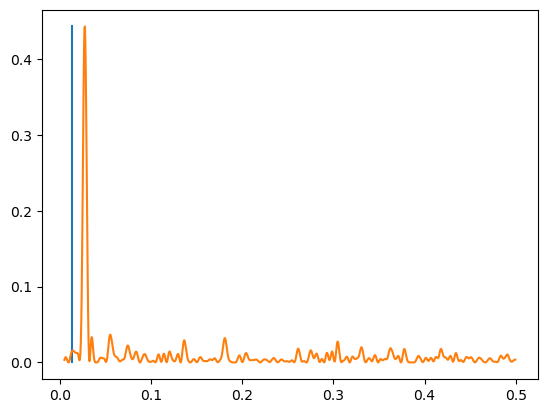

In [105]:
i = 8
i = 12
i = 14
i = 32
print(X_max_values2[i])
print(Y2[i])
print(F[i])
if ( F[i] !=0):
    plt.plot( [F[i],F[i]] , [min(X_LS2[i]), max(X_LS2[i])])
plt.plot(freq,X_LS2[i])

In [49]:
A1, A2, A3  = 0.027, 0.003, 0.3*1e-3 # m/s
B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
cste        = 1.4e-4 # (m/s)**2/Hz

params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]
    
    
LS = []

for i in range(4000):
    
    Prot = random.randint(10,90)*3600*24#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

    amp  = gamma.rvs(2.0, 0.5) 
    epsilon = uniform.rvs(0.5, 1)
    tau = np.random.normal(3*Prot, 0.1*Prot)         
    gam  = 2.0/epsilon #not change
    logP = np.log(Prot) #not change 
    met  = 1.0 # not change 

    params_act = [amp, gam, logP, met]
        
    y_noise, yerr = generate_regular_data_H0(params_gr, params_act, len(t), t) 
    LS.append(LombScargle(t, y_noise).power(freq,method='cython'))

LS_moy = np.mean(LS, axis = 0)

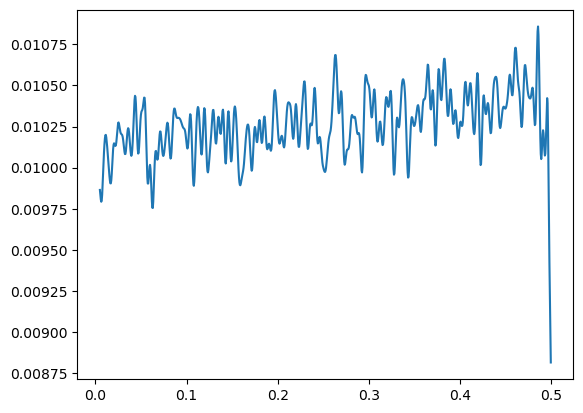

In [50]:
plt.plot(freq, LS_moy)

(<Axes: >, [<matplotlib.lines.Line2D at 0x7fd54cd81450>])

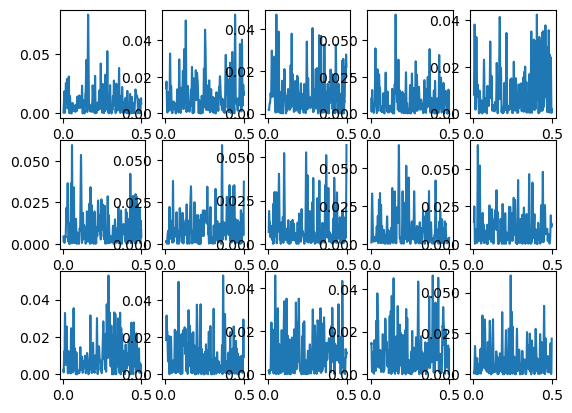

In [51]:
plt.subplot(351), plt.plot(freq,LS[0])
plt.subplot(352), plt.plot(freq,LS[1])
plt.subplot(353), plt.plot(freq,LS[2])
plt.subplot(354), plt.plot(freq,LS[3])
plt.subplot(355), plt.plot(freq,LS[4])
plt.subplot(356), plt.plot(freq,LS[5])
plt.subplot(357), plt.plot(freq,LS[6])
plt.subplot(358), plt.plot(freq,LS[7])
plt.subplot(359), plt.plot(freq,LS[8])
plt.subplot(3,5,10), plt.plot(freq,LS[100])
plt.subplot(3,5,11), plt.plot(freq,LS[1000])
plt.subplot(3,5,12), plt.plot(freq,LS[1500])
plt.subplot(3,5,13), plt.plot(freq,LS[2000])
plt.subplot(3,5,14), plt.plot(freq,LS[2500])
plt.subplot(3,5,15), plt.plot(freq,LS[3500])

In [54]:
A1, A2, A3  = 0.027, 0.003, 0.3*1e-3 # m/s
B1, B2, B3  = 7.4*3600, 1.2*3600, 17.9*60 # seconds
C1, C2, C3  = 3.1, 3.9, 8.9 # dimensionless
AL, Gm, nu0 = 2.6*1e-3, 0.36*1e-3, 2.4*1e-3 # (m/s), Hz, Hz
cste        = 1.4e-4 # (m/s)**2/Hz

params_gr = [A1, A2, A3, B1, B2, B3, C1, C2, C3, AL, Gm, nu0, cste]



Y_gr = []
Y_act = []
Yerr = []

ls_gr = []
ls_act = []
ls_err = []

for i in range(1000):
    
    Prot = random.randint(10,90)*3600*24#62 # days -- Prot to be chosen randomly in HARPS sample (see paper)

    amp  = gamma.rvs(2.0, 0.5) 
    epsilon = uniform.rvs(0.5, 1)
    tau = np.random.normal(3*Prot, 0.1*Prot)         
    gam  = 2.0/epsilon #not change
    logP = np.log(Prot) #not change 
    met  = 1.0 # not change 

    params_act = [amp, gam, logP, met]
    
    ygr, yact, yerr = generate_regular_data_H0(params_gr, params_act, len(t), t)
    Y_gr.append(ygr)
    Y_act.append(yact)
    Yerr.append(yerr)
    ls_gr.append(LombScargle(t, ygr).power(freq, method = 'cython') )
    ls_act.append(LombScargle(t, yact).power(freq, method = 'cython') )
    ls_err.append(LombScargle(t, yerr).power(freq, method = 'cython'))
    
y_gr_moy = np.mean(Y_gr, axis =0)
ls_gr_moy = np.mean(ls_gr, axis = 0)

y_act_moy = np.mean(Y_act, axis =0)
ls_act_moy = np.mean(ls_act, axis = 0)

yerr_moy = np.mean(Yerr, axis =0)
ls_err_moy = np.mean(ls_err, axis = 0)


(<Axes: >, [<matplotlib.lines.Line2D at 0x7fd54cb66440>])

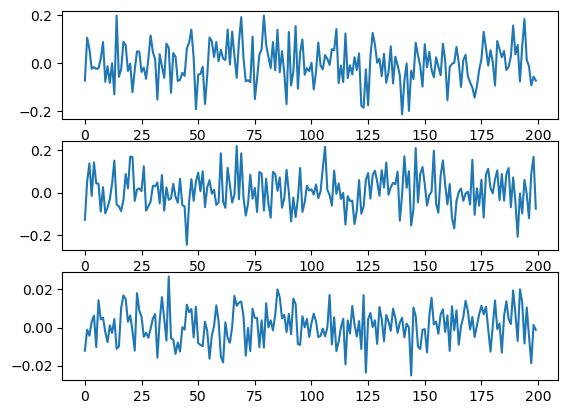

In [55]:
plt.subplot(311), plt.plot(y_gr_moy, label ='granulation')
plt.subplot(312), plt.plot(y_act_moy, label='activity')
plt.subplot(313), plt.plot(yerr_moy, label="errors")

(<Axes: >,
 <matplotlib.legend.Legend at 0x7fd54c6b53f0>)

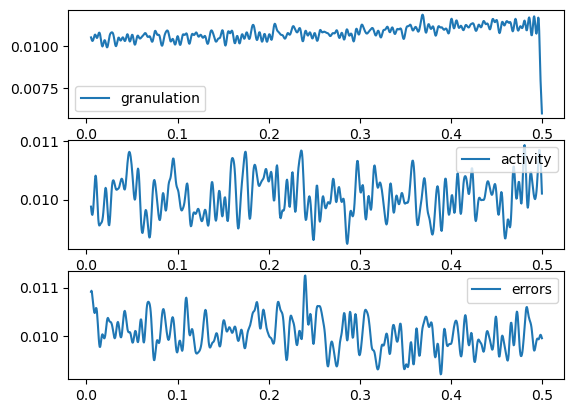

In [59]:
plt.subplot(311), plt.plot(freq,ls_gr_moy,label ='granulation'), plt.legend()
plt.subplot(312), plt.plot(freq,ls_act_moy, label='activity'), plt.legend()
plt.subplot(313), plt.plot(freq,ls_err_moy, label="errors"), plt.legend()

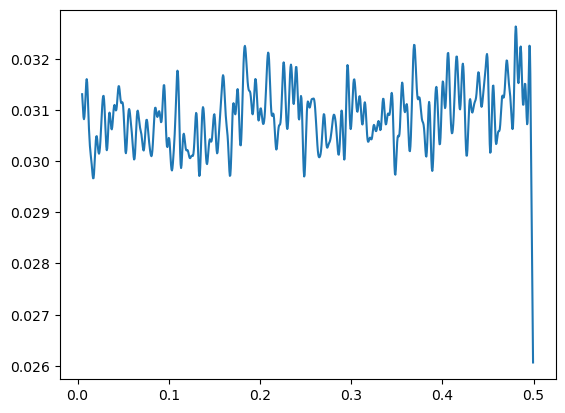

In [60]:
plt.plot(freq,ls_gr_moy + ls_act_moy +ls_err_moy)

In [24]:
ls_gr_moy[-1]

0.005455564325573957

In [34]:
ls_gr_moy[985]

0.007845823305165076